### Prepare Data

In [ ]:
import os
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

folder = r"C:\Users\6eggr\Desktop\Python\New folder\daily_data"
tickers = [f[:-4] for f in os.listdir(folder) if f.endswith(".csv")]

# Set lookback period to calculate returns e.g. 6 months, 12 months
lookback_period = 6
monthly_dfs = {}

for ticker in tickers:
    file_path = os.path.join(folder, f"{ticker}.csv")
    try:
        df = pd.read_csv(file_path)
    except Exception as e:
        continue

    if 'Date' not in df.columns or 'Open' not in df.columns or 'Close' not in df.columns:
        continue

    df['Date'] = pd.to_datetime(df['Date'].astype(str).str.slice(0, 10), errors='coerce')
    df.dropna(subset=['Date'], inplace=True)
    df.set_index('Date', inplace=True)
    df.sort_index(inplace=True)

    try:
        monthly_open = df['Open'].resample('M').first()
        monthly_close = df['Close'].resample('M').last()
    except Exception as e:
        continue

    monthly_data = pd.DataFrame({
        'Monthly_Open': monthly_open,
        'Monthly_Close': monthly_close,
    })

    # Calculate THIS month's return from open to close
    # Assumes entering trades on the first of month using signals calculated
    # at the close of the prior month
    monthly_data['Monthly_Change'] = (
        (monthly_data['Monthly_Close'] - monthly_data['Monthly_Open'])
        / monthly_data['Monthly_Open']
    )

    # Caclulate return over lookback period from the lookback period to the prior month's close
    # to rank stocks
    monthly_data['Lookback_Return'] = (
        (monthly_data['Monthly_Close'].shift(1) 
         - monthly_data['Monthly_Close'].shift(1 + lookback_period))
        / monthly_data['Monthly_Close'].shift(1 + lookback_period)
    )

    monthly_dfs[ticker] = monthly_data

all_monthly_data = pd.concat(monthly_dfs, axis=0).reset_index()
all_monthly_data.columns = [
    'Ticker', 'Date', 'Monthly_Open', 'Monthly_Close',
    'Monthly_Change', 'Lookback_Return'
]

start_date = '2015-01-01'
all_monthly_data = all_monthly_data[all_monthly_data['Date'] >= start_date]

all_monthly_data = all_monthly_data.sort_values('Date')

all_monthly_data.head()


,Ticker,Date,Monthly_Open,Monthly_Close,Monthly_Change,Lookback_Return
182,A,2015-01-31,37.994091,34.847897,-0.082807,-0.001267
24052,BIIB,2015-01-31,342.839996,389.160004,0.135107,0.076560
116770,LYB,2015-01-31,48.614281,48.097359,-0.010633,-0.175429
116999,LYV,2015-01-31,26.219999,23.770000,-0.093440,0.057513
70654,EXPE,2015-01-31,81.322637,81.655243,0.004090,0.088293


### Evaluate Strategy

##### Note: Because I am simply exiting all positions at the first of month then reentering, trading fees will be slightly overapplied since some positions that should rollover are sold then bought again. This allows simpler logic to simulate rebalancing the portfolio each month to maintain equal weighted positions.

[*********************100%***********************]  1 of 1 completed


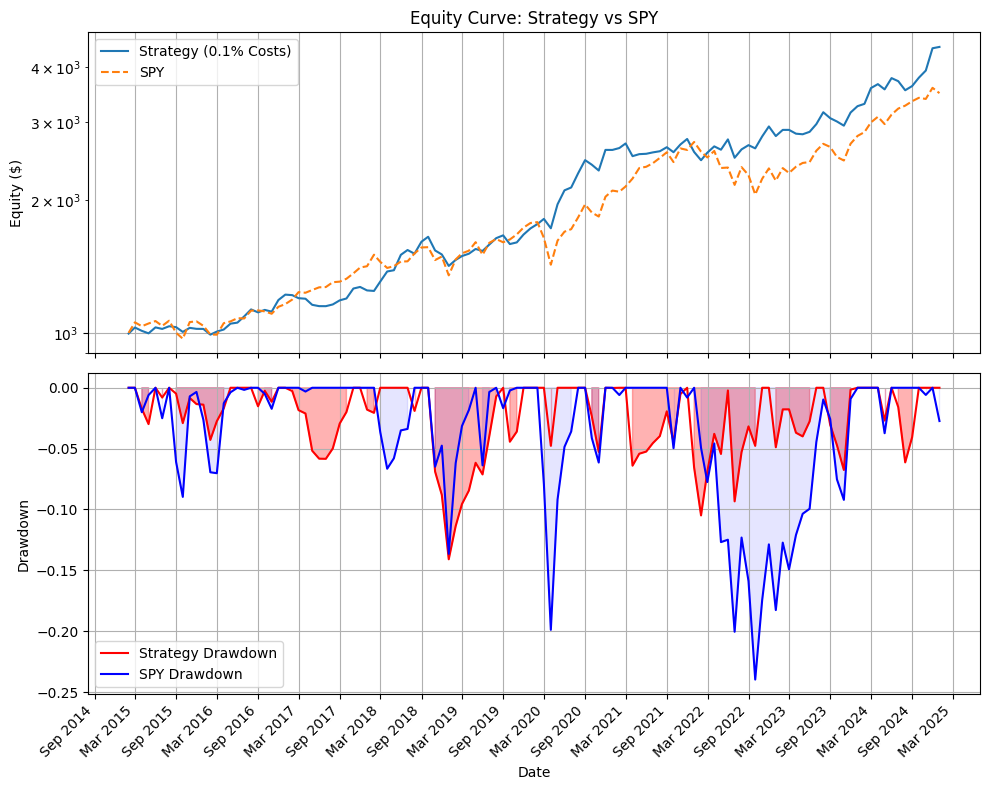

In [191]:
import yfinance as yf

# number of stocks to buy each month
top_n = 5

# Pick the top 5 by Lookback_Return each month,
# then take the *mean* of their Monthly_Change from this month's open to close
# assumes monthly rebalancing to deploy equal amounts of capital to each stock

# e.g. if PLTR, AAPL, TSLA, CLX, & META are top performing stocks over the six month lookback period as
# of this months close, we buy each with equal weight at the beginning of the next month
monthly_top_five = (
    all_monthly_data
    .groupby('Date', group_keys=False)
    .apply(lambda df: df.nlargest(top_n, 'Lookback_Return')['Monthly_Change'].mean())
    .reset_index(name='Avg_Monthly_Return')
)

# Parameters for the portfolio simulation
initial_capital = 1000
transaction_cost_rate = 0.0005
fraction_of_capital = 0.4
equity_values = []
current_value = initial_capital

# Simulate the monthly equity curve
for i, row in monthly_top_five.iterrows():
    
    monthly_r = row['Avg_Monthly_Return']
        
    invested_capital = current_value * fraction_of_capital
        
    cost = invested_capital * transaction_cost_rate
        
    net_invested_capital = invested_capital - cost
        
    leftover = current_value - invested_capital
        
    new_invested_value = net_invested_capital * (1 + monthly_r)
        
    current_value = leftover + new_invested_value
        
    equity_values.append(current_value)

monthly_top_five['Equity'] = equity_values

# Download SPY data
SPY = yf.download('SPY', start='2015-01-01', interval='1mo')
SPY['Equity'] = SPY['Close']  # Use Close prices for SPY
SPY['Equity'] = SPY['Equity'] / SPY['Equity'].iloc[0] * 1000  # Normalize to start at 1,000
SPY['RollingMax'] = SPY['Equity'].cummax()
SPY['Drawdown'] = (SPY['Equity'] / SPY['RollingMax']) - 1


monthly_top_five['RollingMax'] = monthly_top_five['Equity'].cummax()
monthly_top_five['Drawdown'] = (monthly_top_five['Equity'] / monthly_top_five['RollingMax']) - 1

# Ensure monthly_top_five dates are aligned to the last day of the month
monthly_top_five['Date'] = pd.to_datetime(monthly_top_five['Date']) + pd.offsets.MonthEnd(0)

#Ensure date alignment
SPY.index = SPY.index + pd.offsets.MonthEnd(0)

common_range = pd.date_range(start=monthly_top_five['Date'].min(), end=monthly_top_five['Date'].max(), freq='M')
SPY = SPY.loc[SPY.index.isin(common_range)]
monthly_top_five = monthly_top_five[monthly_top_five['Date'].isin(SPY.index)]


import matplotlib.dates as mdates  

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)

axes[0].plot(monthly_top_five['Date'], monthly_top_five['Equity'], label='Strategy (0.1% Costs)')
axes[0].plot(SPY.index, SPY['Equity'], label='SPY', linestyle='--') 
axes[0].set_title('Equity Curve: Strategy vs SPY')
axes[0].set_ylabel('Equity ($)')
axes[0].set_yscale('log')
axes[0].grid(True)
axes[0].legend()

# Drawdown visualization
axes[1].plot(monthly_top_five['Date'], monthly_top_five['Drawdown'], color='red', label='Strategy Drawdown')
axes[1].plot(SPY.index, SPY['Drawdown'], color='blue', label='SPY Drawdown')
axes[1].fill_between(monthly_top_five['Date'], monthly_top_five['Drawdown'], 0, 
                     where=monthly_top_five['Drawdown'] < 0, color='red', alpha=0.3)
axes[1].fill_between(SPY.index, SPY['Drawdown'], 0, 
                     where=SPY['Drawdown'] < 0, color='blue', alpha=0.1)  # Fill SPY drawdown
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Drawdown')
axes[1].grid(True)
axes[1].legend()


axes[1].xaxis.set_major_locator(mdates.MonthLocator(interval=6))  
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y')) 

plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [181]:
monthly_top_five.head()

,Date,Avg_Monthly_Return,Equity,RollingMax,Drawdown
0,2015-01-31,-0.008826,996.073098,996.073098,0.000000
1,2015-02-28,0.080385,1027.670461,1027.670461,0.000000
2,2015-03-31,-0.042724,1009.714629,1027.670461,-0.017472
3,2015-04-30,-0.031517,996.594364,1027.670461,-0.030239
4,2015-05-31,0.079246,1027.754541,1027.754541,0.000000


### Out of curiosity I tested the same strategy on ARK holdings
##### I always thought ARK was especially bad at trading (like buying ZM at 500+/share) but since systems are more about where they are applied, I figured the ARK stock universe could work very well with simple strategies
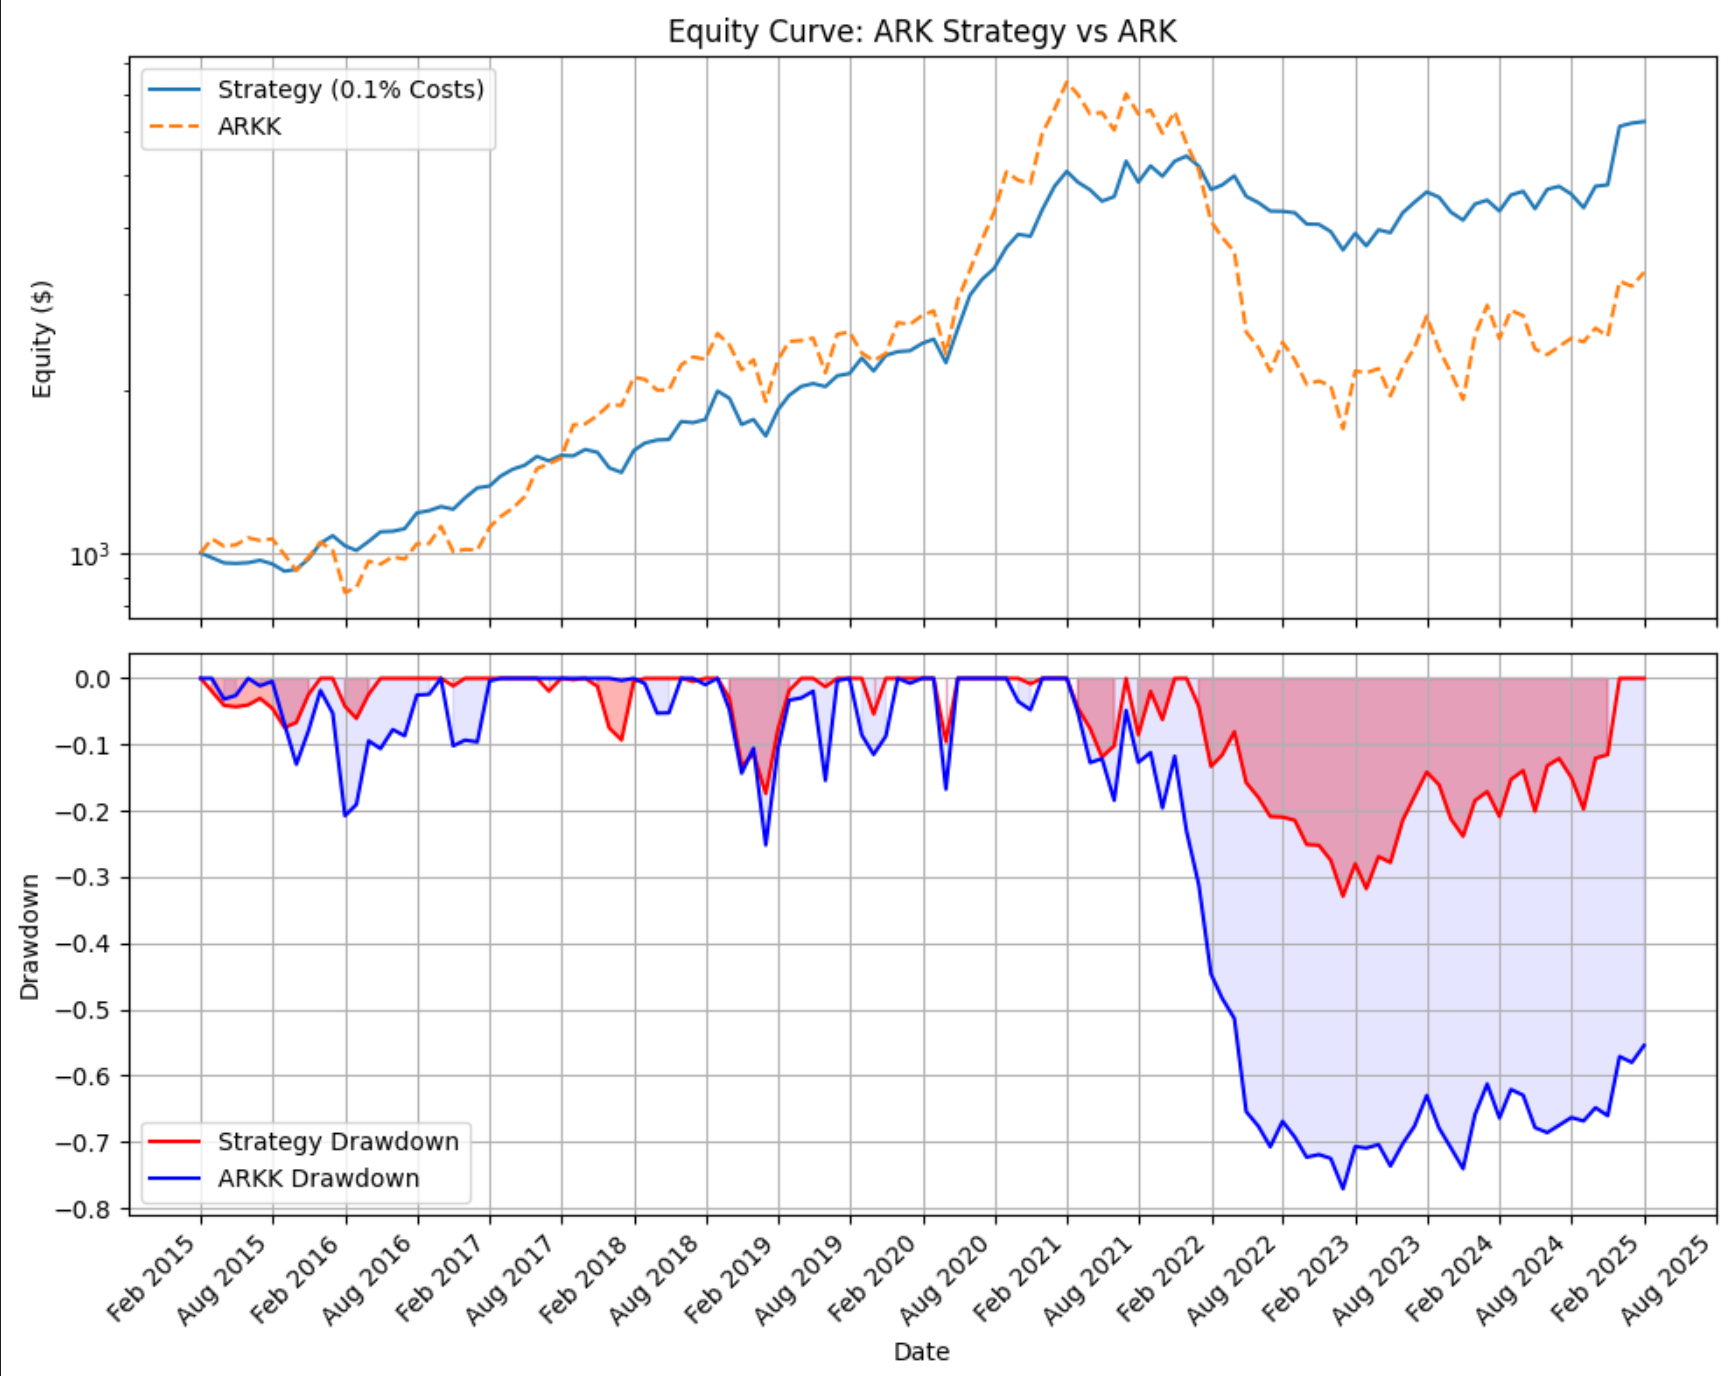

#### What next: Create ensemble of Long/Short simple strategies to apply across various sector groups of stocks and assets to achieve multiple uncorrelated strategies